#  Hw 3 Principal Component Analysis

In [280]:
import os
from time import time
import pandas as pd
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from skimage.transform import rescale
import matplotlib.cm as cm

Lets define a function that can import and image as grey, and then rescale the image to downsize it by 3.0 times the orignal size. This will help us with our calculation of the covariant matrix to find the eigenvectors later.

In [230]:
def import_image(filename):
    image = io.imread('yalefaces/' +filename, as_grey = True)
    image_resize = rescale(image,1.0/4.0)
    size = image_resize.shape
    image_flat = [item for sub in image_resize for item in sub]
    return image_flat, image_resize, size

Import the images by using the list directory from the yaleface folder.

In [231]:
# list_of_images = os.listdir('yalefaces')
list_of_images = os.listdir('yalefaces')  #import the filenames as a list
data = pd.DataFrame(list_of_images)

Create a Pandas Dataframe which contains the subject, the expression, the filename and the flattened image data.

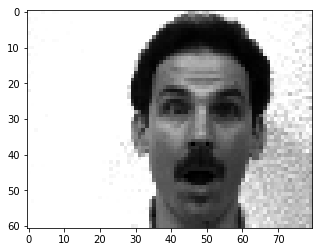

size of image:  (61, 80)


In [232]:
data = []
for title in list_of_images:
    row = {}
    row['filename'] = title
    row['subject'] = title.split('.')[0]
    row['expression'] = title.split('.')[1]
    row['flat'], row['resized'], shape = import_image(title)
    data.append(row)
data = pd.DataFrame.from_records(data)
plt.imshow(data['resized'][2], cmap = cm.gray)
plt.show()
print "size of image: ",shape

Now we will normalize the Data by calculating the mean of the row and then divinding each value in the row by the mean.

In [233]:
for row in range(data['flat'].count()):
    entries = len(data['flat'][0])
    numerator = 0
    for entry in data['flat'][row]:
        numerator += entry
    mean = numerator/entries
    data['resized'][row] = data['resized'][row] / mean
    data['flat'][row] = data['flat'][row] / mean

We now normalize the data by dividing the entries by the mean

### Lets compute the covariance matrix. I used the slided from **class** which say 

$$ S =  \frac{1}{N} X^T X $$

which gives us a dimensionality of: **{DxD}**

In [234]:
X = []
for row in range(data['flat'].count()):
    img_mean =  np.array([data['flat'][row]])
    img_mean =  img_mean[0]
    X.append(img_mean)
X = np.array(X)
S = np.dot(X.T,X)/len(X)

In [235]:
eigenvalues,eigenvectors =  np.linalg.eig(S)  #lets find the eigenvalues and vectors

In [236]:
idx = eigenvalues.argsort()[::-1] #large to small
eigenvalues = eigenvalues[idx]   #orders the eignevalues
eigenvectors = eigenvectors[:,idx]  #orders the eignevtors as columns

We have obtained 4880 eigenvalues


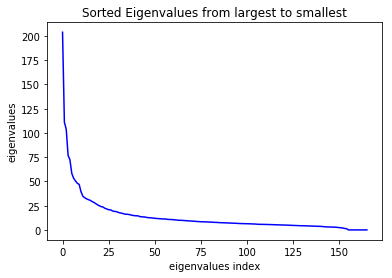

In [263]:
print "We have obtained", len(eigenvalues), "eigenvalues"
a = range(len(eigenvalues))
plt.plot(range(len(S)), S, 'b')
plt.xlabel("eigenvalues index")
plt.ylabel("eigenvalues")
plt.title("Sorted Eigenvalues from largest to smallest")
plt.show()
Uvector =  eigenvectors[:,0:10]   #take the first ten 
Ueigen = eigenvalues[0:10]     #take the corresponding eigenvectors

In [270]:
half_energy =  sum(S)/2
runningsum = 0
k = 0
for value in S:
    if runningsum < half_energy:
        runningsum += value
        k +=1
print "the number of eigenvalues to reach half energy is: ", k
print k, " <- are the number of eigenvalues needed to reach half energy of -> ", float(half_energy)

the number of eigenvalues to reach half energy is:  22
22  <- are the number of eigenvalues needed to reach half energy of ->  1165.65077018


#### Then number of eigenvalues necessary to reach 50% of the energy of the system is above


Now I will print out the dimensionalities of our matrices for clear computations

In [239]:
print X.shape, "X original NxD"
print S.shape,  "S that is DxD"
print Uvector.shape , "U which is DxM"
print Uvector.T.shape , "UT which is MxD"
print np.dot(X,Uvector).shape, "X dot Ut which is NxM Dimensionality reduced!"

(166, 4880) X original NxD
(4880, 4880) S that is DxD
(4880, 10) U which is DxM
(10, 4880) UT which is MxD
(166, 10) X dot Ut which is NxM Dimensionality reduced!


# Top 10 Eigenfaces

### From the computed eignevectors, we can extract the eigenfaces.

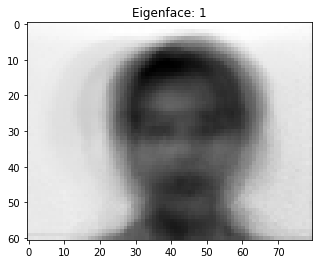

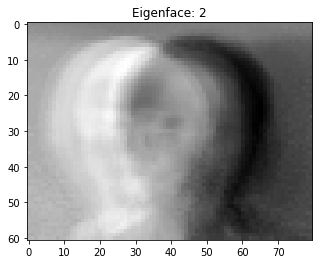

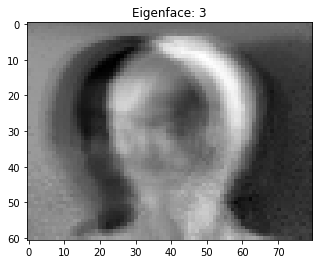

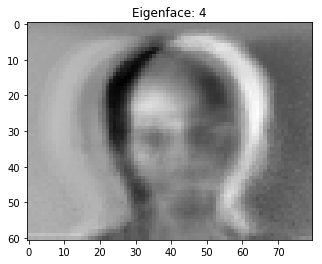

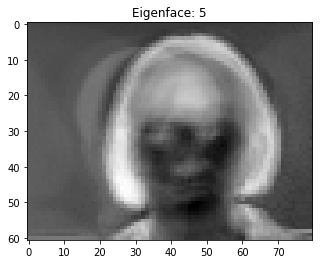

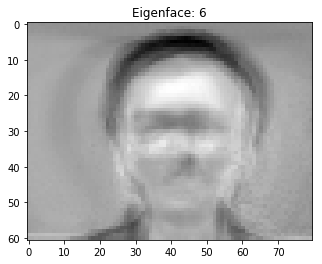

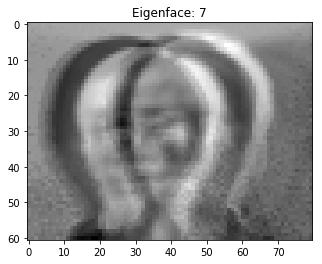

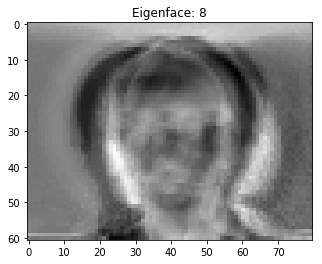

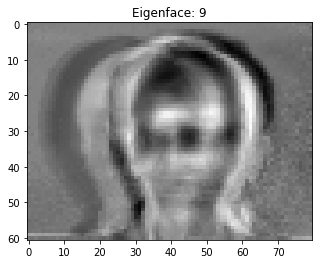

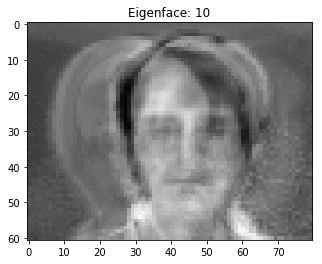

In [244]:
for i in range(10):
    UT =  Uvector.T[i]
    temp = UT.real
    temp = temp.reshape( shape )
    plt.imshow(temp, cmap = cm.gray)
    plt.title("Eigenface: "+str(i+1))
    plt.show()

### Reconstructing different images from the eigenfaces.

In this section, I will try to reconstruct the different input images by using different number of eigenfaces. I will use the following equation:

$$ \textbf{x} \approx \textbf{x0} + \sum_{k=1}^{K} \boldsymbol{c_k u_k}$$

where 

$$ c_k = \boldsymbol{u_k ^T x}$$


In [241]:
mu = np.mean(X,0)   #find the mean face of our input images
ma_data = X - mu    #mean adjust the data 
U, S, V = np.linalg.svd(ma_data.transpose(), full_matrices=False)  #use Singular Value Decomposition
weights = np.dot(ma_data, U)  #our U matrix is the eigenvectors, now we compute the weights

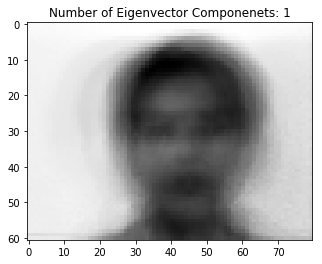

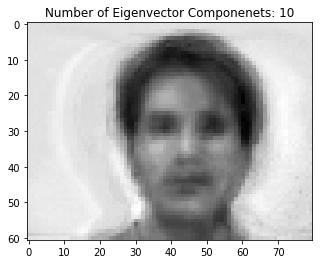

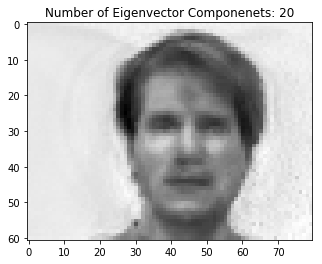

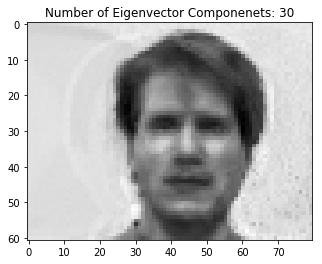

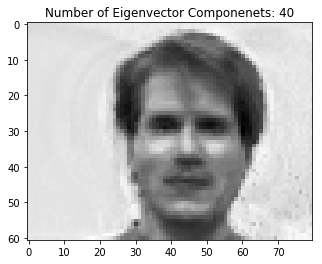

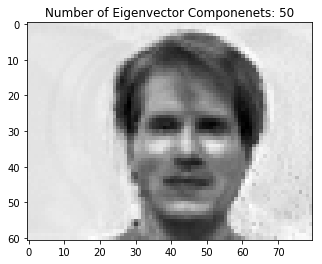

In [297]:
k = [1,10,20,30,40,50]  #number of eigenvectors used to reconstruct the image
for eigen in k:
    recon = mu + np.dot(weights[6, 0:eigen], U[:, 0:eigen].T)
    plt.imshow(recon.reshape(shape), cmap = cm.gray)
    plt.title("Number of Eigenvector Componenets: "+str(eigen))
    plt.show()

As we can see, It is usually best to use more than 1 eigenvector to reconstruct our image. In my case, since the resize function compresses our data by a significant ammount, by the **50th eigenvector, we have reconstructed a very nice looking image compared to our original resized input. ** More eigenfaces will be a better reconstruction of our image!

## Face Recognition

I will try to identify the subject based on the recation. By splitting the data into training and testing I can then train a Support Vector Machine to identify the correct subject number from the training set images.

In [277]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.33)

In [377]:
y_train, y_test = [], []
for ids in train['subject']:
    y_train.append(ids[7:9])
for ids in test['subject']:
    y_test.append(ids[7:9])

In [416]:
from sklearn import svm
t0 = time()
A = train['flat'].values.tolist()
B = test['flat'].values.tolist()
clf = svm.SVC(kernel="linear",C=100000)
clf.fit(A,y_train)
print ("Training Time:"),(round(time()-t0,3)),("s")

Training Time: 0.105 s


In [419]:
tp = time()
pred = clf.predict(B)

from sklearn.metrics import accuracy_score
count = 0
for i in range(len(pred)):
    if pred[i] == y_test[i]:
        count += 1

print ("Time Predict:"),(round(time()-tp,3)),("s")
print("Accuracy: "), (accuracy_score(pred, y_test))*100,"%"
print ("final count: "),(count)

Time Predict: 0.03 s
Accuracy:  90.9090909091 %
final count:  50


By using a **Linear Kernel** with a **C = 100,000** . This gives an Accuracy of classifying correctly:

## Accuracy: 90.9%!